In [1]:
import nibabel as nib
from matplotlib import pyplot as plt
import numpy as np
import cv2
from skimage.segmentation import expand_labels

In [2]:
def array2cv(array) :
    slice = (array * 255).astype(np.uint8)
    return slice

In [3]:
def fillhole(img):

    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        # Assuming the smallest contour is the hole (this might need adjustment based on your image)
        contours = sorted(contours, key=cv2.contourArea)
        hole = contours[0]  # Change the index based on your specific image

        # Create a color version of the binary image if you want to fill the hole in color or visualize
        color_image = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        # Draw the contour to fill the hole
        cv2.drawContours(color_image, [hole], 0, (255, 255, 255), -1)
    
    return color_image

In [4]:
def cv2array(cv_img):
    gray_image = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)
    _, binary_image_final = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
    return binary_image_final

In [5]:
import os

input_folder = r"D:\Kananat\Segmentation"
output_folder = r"D:\Kananat\Augmented_segmentation_dim1_expand0px"
expand_distance = 1

nii_count = len([filename for filename in os.listdir(input_folder) if filename.endswith('.nii.gz')])
print(f"There are {nii_count} .nii.gz files in the {input_folder}")

progress_count = 0

files = sorted(os.listdir(input_folder))

for input_name in files :
    if input_name.endswith('.nii.gz'):
        progress_count += 1
        print(f"[Processing {progress_count} out of {nii_count}]")
        
        input_path = os.path.join(input_folder, input_name)

        output_name = os.path.basename(input_path)
        output_name, _ = os.path.splitext(output_name)
        output_name, _ = os.path.splitext(output_name)
        output_name = f"{output_name}_augmented.nii.gz"

        output_path = os.path.join(output_folder, output_name)

        img = nib.load(input_path)
        data = img.get_fdata()
        new_data = np.zeros_like(data)

        for slice_number in range(new_data.shape[0]):
            slice = data[slice_number,:,:]
            slice = expand_labels(slice, distance=expand_distance)
            cv_img = array2cv(slice)
            filled_cv_img = fillhole(cv_img)
            array_img = cv2array(filled_cv_img)
            new_data[slice_number,:,:] = array_img

        result_img = nib.Nifti1Image(new_data, img.affine, img.header)
        nib.save(result_img, output_path)

There are 365 .nii.gz files in the D:\Kananat\Segmentation
[Processing 1 out of 365]
[Processing 2 out of 365]
[Processing 3 out of 365]
[Processing 4 out of 365]
[Processing 5 out of 365]
[Processing 6 out of 365]
[Processing 7 out of 365]
[Processing 8 out of 365]
[Processing 9 out of 365]
[Processing 10 out of 365]
[Processing 11 out of 365]
[Processing 12 out of 365]
[Processing 13 out of 365]
[Processing 14 out of 365]
[Processing 15 out of 365]
[Processing 16 out of 365]
[Processing 17 out of 365]
[Processing 18 out of 365]
[Processing 19 out of 365]
[Processing 20 out of 365]
[Processing 21 out of 365]
[Processing 22 out of 365]
[Processing 23 out of 365]
[Processing 24 out of 365]
[Processing 25 out of 365]
[Processing 26 out of 365]
[Processing 27 out of 365]
[Processing 28 out of 365]
[Processing 29 out of 365]
[Processing 30 out of 365]
[Processing 31 out of 365]
[Processing 32 out of 365]
[Processing 33 out of 365]
[Processing 34 out of 365]
[Processing 35 out of 365]
[Proc

(417, 477, 481)


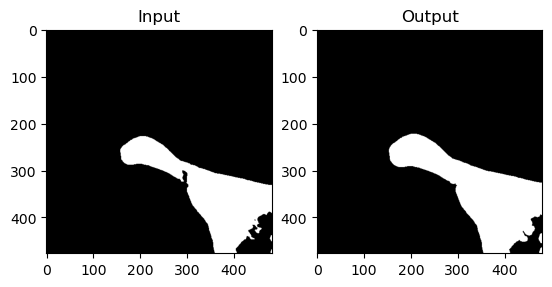

In [6]:
# Result Example

file_path = r"D:\Kananat\Segmentation\5450 L_segmented.nii.gz"
img = nib.load(file_path)
data = img.get_fdata()
print(data.shape)

slice_number = 260

slice = data[slice_number,:,:]

#expand the edge of the segmentation a little
slice = expand_labels(slice, distance=5)

#fill the hole if there are holes
cv_img = array2cv(slice)
filled_cv_img = fillhole(cv_img)
array_img = cv2array(filled_cv_img)

#display result
f, axarr = plt.subplots(1,2)
axarr[0].set_title("Input")
axarr[0].imshow(data[slice_number,:,:], cmap = 'grey')
axarr[1].set_title("Output")
axarr[1].imshow(array_img, cmap = 'grey')